<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/DeepXDE_PINNRobustIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PINN

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ===== PINN UV-Vis with DeepXDE: end-to-end notebook =====

import os, random, warnings, glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import deepxde as dde
import matplotlib.pyplot as plt

# Reproducibility
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(1337)
print("DeepXDE", dde.__version__)

# ===== Paths and constants =====
# Change DATA_PATH if you use Drive
DATA_PATH = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"
REQUIRED_COLS = ["Wavelength","0","10","20","30","40","60"]
C_LEVELS = [0,10,20,30,40,60]
B_PATHLEN_CM = 1.0

_LAM_MIN, _LAM_MAX = 200.0, 800.0
_C_MIN, _C_MAX = 0.0, 60.0
_dlam_dlamhat = (_LAM_MAX - _LAM_MIN) / 2.0
_dc_dchat = (_C_MAX - _C_MIN) / 2.0

DeepXDE 1.14.0


In [5]:

# ===== Phase 1: Data loading and preprocessing =====
def load_uvvis_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing CSV at {path}")
    df = pd.read_csv(path)
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing required columns: {missing}")
    if len(df) != 601:
        raise ValueError(f"Expected 601 wavelength points. Got {len(df)}")
    return df

def preprocess(df: pd.DataFrame):
    df_sorted = df.sort_values("Wavelength", ascending=True).reset_index(drop=True)
    wl = df_sorted["Wavelength"].to_numpy().astype(np.float32)

    A_bg = df_sorted["0"].to_numpy().astype(np.float32)
    deltas = {}
    for c in C_LEVELS:
        A = df_sorted[str(c)].to_numpy().astype(np.float32)
        deltas[c] = (A - A_bg).astype(np.float32)

    wl_norm = 2.0 * (wl - _LAM_MIN) / (_LAM_MAX - _LAM_MIN) - 1.0
    return dict(wl=wl, wl_norm=wl_norm.astype(np.float32), A_bg=A_bg, deltas=deltas)

df = load_uvvis_csv(DATA_PATH)
prep = preprocess(df)
print("Data OK:", len(prep["wl"]), "points")

Data OK: 601 points


In [11]:

# ===== Phase 2: Network definition (epsilon_net) =====
def create_epsilon_net(hidden=3, width=64):
    layer_sizes = [2] + [width]*hidden + [1]
    net = dde.nn.FNN(layer_sizes, "tanh", "Glorot uniform")
    def output_transform(x, y):  # enforce epsilon >= 0
        return tf.nn.softplus(y)
    net.apply_output_transform(output_transform)
    return net

# ===== Phase 3: PINN residuals (physics + smoothness) =====
def pinn_pde_residual(x, y):
    """
    Returns 2 residuals per point:
      r_phys   = d/dc ΔA_model - b*(ε + c*ε_c)
      r_smooth = ∂²ε/∂λ²
    """
    c_hat = x[:, 1:2]
    c = 0.5 * (c_hat + 1.0) * (_C_MAX - _C_MIN) + _C_MIN

    eps = y
    deltaA = B_PATHLEN_CM * c * eps

    dDeltaA_dc_hat = dde.grad.jacobian(deltaA, x, i=0, j=1)
    dDeltaA_dc = dDeltaA_dc_hat / _dc_dchat

    deps_dc_hat = dde.grad.jacobian(eps, x, i=0, j=1)
    eps_c = deps_dc_hat / _dc_dchat

    r_phys = dDeltaA_dc - (B_PATHLEN_CM * (eps + c * eps_c))

    d2eps_dlamhat2 = dde.grad.hessian(eps, x, i=0, j=0)
    eps_lamlam = d2eps_dlamhat2 / (_dlam_dlamhat ** 2)
    r_smooth = eps_lamlam

    return tf.concat([r_phys, r_smooth], axis=1)

# ===== Helpers: supervised labels as epsilon and dataset builder =====
def make_eps_targets(prep, c_values=(10,20,30,40,60), b_cm=1.0, debug=True):
    wl_norm = np.asarray(prep["wl_norm"], dtype=np.float32)
    assert wl_norm.ndim == 1 and wl_norm.shape[0] == 601, f"wl_norm bad shape: {wl_norm.shape}"
    wl_hat = wl_norm.reshape(-1, 1)  # (601,1)

    X_list, eps_list = [], []
    if debug:
        print("make_eps_targets: c_values =", list(c_values))

    for c in c_values:
        c_raw = float(c)
        assert c_raw > 0.0, f"c must be > 0 for epsilon labels, got {c}"
        n = wl_hat.shape[0]

        c_hat = 2.0 * (c_raw - 0.0) / (60.0 - 0.0) - 1.0
        c_col = np.full((n, 1), c_hat, dtype=np.float32)

        Xc = np.hstack([wl_hat, c_col]).astype(np.float32)
        assert Xc.ndim == 2 and Xc.shape == (n, 2), f"Xc bad shape for c={c}: {Xc.shape}"

        delta = np.asarray(prep["deltas"][c], dtype=np.float32).reshape(-1, 1)
        assert delta.shape == (n, 1), f"delta bad shape for c={c}: {delta.shape}"

        eps = (delta / (b_cm * c_raw)).astype(np.float32)
        assert eps.ndim == 2 and eps.shape == (n, 1), f"eps bad shape for c={c}: {eps.shape}"

        if debug:
            print(f"  c={c}: Xc {Xc.shape}, eps {eps.shape}, finite={np.isfinite(eps).all()}")

        X_list.append(Xc)
        eps_list.append(eps)

    assert len(X_list) > 0 and len(eps_list) > 0, "No training blocks were built — c_values may be empty."

    # Extra shape guard before concatenation
    for i, Xi in enumerate(X_list):
        assert Xi.shape[1] == 2, f"X_list[{i}] has {Xi.shape[1]} cols (expected 2)."
    for i, Yi in enumerate(eps_list):
        assert Yi.shape[1] == 1, f"eps_list[{i}] has {Yi.shape[1]} cols (expected 1)."

    X = np.concatenate(X_list, axis=0).astype(np.float32)
    eps_y = np.concatenate(eps_list, axis=0).astype(np.float32)

    assert X.ndim == 2 and X.shape[1] == 2, f"Final X bad shape: {X.shape}"
    assert eps_y.ndim == 2 and eps_y.shape[1] == 1 and eps_y.shape[0] == X.shape[0], f"Final eps_y bad shape: {eps_y.shape}"
    return X, eps_y


def build_pinn_dataset(prep, held=None):
    train_cs = [10,20,30,40,60] if held is None else [c for c in [10,20,30,40,60] if c != held]
    print("build_pinn_dataset: held =", held, "train_cs =", train_cs)  # debug
    X_train, y_train = make_eps_targets(prep, c_values=train_cs, b_cm=B_PATHLEN_CM, debug=True)

    test_cs  = [] if held is None else [held]
    if test_cs:
        X_test, y_test = make_eps_targets(prep, c_values=test_cs, b_cm=B_PATHLEN_CM, debug=True)
    else:
        X_test, y_test = X_train[:512], y_train[:512]

    geom = dde.geometry.Rectangle(xmin=[-1.0, -1.0], xmax=[1.0, 1.0])
    bc_data = dde.icbc.PointSetBC(X_train, y_train)
    data = dde.data.PDE(
        geom,
        pinn_pde_residual,
        bcs=[bc_data],
        num_domain=0,
        num_boundary=0,
        anchors=X_train,
        num_test=0,
    )
    return data, (X_test, y_test)

In [12]:
# Quick repro for a single fold to see prints
_ = make_eps_targets(prep, c_values=[10,20,30,40,60], b_cm=B_PATHLEN_CM, debug=True)

make_eps_targets: c_values = [10, 20, 30, 40, 60]
  c=10: Xc (601, 2), eps (601, 1), finite=True
  c=20: Xc (601, 2), eps (601, 1), finite=True
  c=30: Xc (601, 2), eps (601, 1), finite=True
  c=40: Xc (601, 2), eps (601, 1), finite=True
  c=60: Xc (601, 2), eps (601, 1), finite=True


In [10]:

# ===== Phase 4: Training with Adam then L-BFGS, checkpoints, LOSO CV =====
def train_once_pinn_ckpt(
    prep,
    held=None,
    seed=1337,
    adam_iters=3000,
    lr=1e-3,
    bfgs=True,
    w_phys=0.1,
    w_smooth=1e-4,
    ckpt_dir="/content/pinn_eps_ckpt_pinn",
):
    set_seed(seed)
    data, (X_test, y_test) = build_pinn_dataset(prep, held=held)
    net = create_epsilon_net()
    model = dde.Model(data, net)

    ckpt_path = os.path.join(ckpt_dir, f"held_{held or 'all'}_seed_{seed}")
    os.makedirs(ckpt_path, exist_ok=True)
    cb_ckpt = dde.callbacks.ModelCheckpoint(
        os.path.join(ckpt_path, "best"),
        save_better_only=True,
        period=1,
        verbose=True,
    )
    cb_early = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=800)

    # Loss order: [r_phys, r_smooth, PointSetBC]
    loss_weights = [w_phys, w_smooth, 1.0]

    model.compile("adam", lr=lr, loss_weights=loss_weights)
    losshistory, train_state = model.train(
        iterations=adam_iters, display_every=500, callbacks=[cb_ckpt, cb_early]
    )

    if bfgs:
        model.compile("L-BFGS", loss_weights=loss_weights)
        losshistory, train_state = model.train(display_every=100, callbacks=[cb_ckpt])

    model.save(os.path.join(ckpt_path, "final"))

    # Test MSE in epsilon space
    y_pred = model.predict(X_test)
    mse_eps = float(np.mean((y_pred - y_test) ** 2))
    return model, losshistory, train_state, mse_eps, ckpt_path

def run_loso_cv_pinn(prep, adam_iters=2000, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4):
    results = {}
    for held in [10, 20, 30, 40, 60]:
        model, _, _, mse_eps, ckpt = train_once_pinn_ckpt(
            prep, held=held, adam_iters=adam_iters, lr=lr, bfgs=bfgs,
            w_phys=w_phys, w_smooth=w_smooth
        )
        results[held] = {"mse_eps": mse_eps, "ckpt": ckpt}
        print(f"Held {held}  MSE_eps={mse_eps:.4e}  ckpt={ckpt}")
    return results

cv_results = run_loso_cv_pinn(prep, adam_iters=2000, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4)
cv_results

make_eps_targets: c_values = [20, 30, 40, 60]
  c=20: Xc (601, 2), eps (601, 1), finite=True
  c=30: Xc (601, 2), eps (601, 1), finite=True
  c=40: Xc (601, 2), eps (601, 1), finite=True
  c=60: Xc (601, 2), eps (601, 1), finite=True
make_eps_targets: c_values = [10]
  c=10: Xc (601, 2), eps (601, 1), finite=True


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 0

In [ ]:

# ===== Phase 5: Prediction, uncertainty, CSV =====
def predict_absorbance_for_c(model, prep, c):
    wl = prep["wl"]; A_bg = prep["A_bg"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    c_hat = 2.0 * (float(c) - _C_MIN) / (_C_MAX - _C_MIN) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
    eps = model.predict(X).reshape(-1)
    A_pred = A_bg + B_PATHLEN_CM * float(c) * eps
    return wl, A_pred

def evaluate_absorbance_metrics(A_true, A_pred):
    rmse = float(np.sqrt(np.mean((A_pred - A_true) ** 2)))
    mae  = float(np.mean(np.abs(A_pred - A_true)))
    ss_res = float(np.sum((A_true - A_pred) ** 2))
    ss_tot = float(np.sum((A_true - np.mean(A_true)) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
    return {"rmse": rmse, "mae": mae, "r2": r2}

def plot_absorbance(wl, A_true, A_pred, title="Prediction"):
    plt.figure()
    if A_true is not None:
        plt.plot(wl, A_true, label="True")
    plt.plot(wl, A_pred, label="Pred")
    plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance")
    plt.title(title); plt.legend(); plt.show()

def export_prediction_csv(path, wl, A, A_lo=None, A_hi=None):
    df = pd.DataFrame({"wavelength_nm": wl, "A": A})
    if A_lo is not None and A_hi is not None:
        df["A_lo"] = A_lo; df["A_hi"] = A_hi
    df.to_csv(path, index=False)
    print("Wrote", path)

# Robust restore for a fold model
def restore_fold_model(prep, held, ckpt, w_phys=0.1, w_smooth=1e-4):
    data, _ = build_pinn_dataset(prep, held=held)
    model = dde.Model(data, create_epsilon_net())
    model.compile("adam", lr=1e-3, loss_weights=[w_phys, w_smooth, 1.0])
    for candidate in ["best", "final"]:
        p = os.path.join(ckpt, candidate)
        try:
            model.restore(p)
            print("Restored from:", p)
            return model
        except Exception as e:
            print("Restore failed at", p, "->", e)
    print("No checkpoint found. Initializing with a tiny train step.")
    model.train(iterations=1, display_every=1)
    print("CKPT contents:", glob.glob(os.path.join(ckpt, "*")))
    return model


In [ ]:


# Demo: evaluate a held fold in absorbance space
held = 40
model_held = restore_fold_model(prep, held, cv_results[held]["ckpt"], w_phys=0.1, w_smooth=1e-4)
wl, A_pred = predict_absorbance_for_c(model_held, prep, held)
A_true = prep["A_bg"] + prep["deltas"][held]
metrics = evaluate_absorbance_metrics(A_true, A_pred)
print("Held metrics:", metrics)
plot_absorbance(wl, A_true, A_pred, title=f"Held {held}  RMSE {metrics['rmse']:.4g}  R2 {metrics['r2']:.4f}")

# Ensemble uncertainty for unseen concentration using full-data training each time
def train_full_pinn(prep, seed=1337, adam_iters=1500, lr=1e-3, bfgs=True, w_phys=0.1, w_smooth=1e-4):
    set_seed(seed)
    data, _ = build_pinn_dataset(prep, held=None)
    model = dde.Model(data, create_epsilon_net())
    model.compile("adam", lr=lr, loss_weights=[w_phys, w_smooth, 1.0])
    model.train(iterations=adam_iters, display_every=500)
    if bfgs:
        model.compile("L-BFGS", loss_weights=[w_phys, w_smooth, 1.0])
        model.train(display_every=100)
    return model


In [ ]:

def ensemble_absorbance(prep, c_new, seeds=(11,22,33), adam_iters=1200, lr=1e-3, w_phys=0.1, w_smooth=1e-4):
    wl = prep["wl"]; A_bg = prep["A_bg"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    c_hat = 2.0 * (float(c_new) - _C_MIN) / (_C_MAX - _C_MIN) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])

    A_list = []
    for s in seeds:
        m = train_full_pinn(prep, seed=s, adam_iters=adam_iters, lr=lr, bfgs=True, w_phys=w_phys, w_smooth=w_smooth)
        eps = m.predict(X).reshape(-1)
        A = A_bg + B_PATHLEN_CM * float(c_new) * eps
        A_list.append(A)
    A_stack = np.stack(A_list, axis=0)
    A_mean, A_std = A_stack.mean(axis=0), A_stack.std(axis=0)
    return wl, A_mean, A_std

wl, A_mean, A_std = ensemble_absorbance(prep, c_new=25, seeds=(101,202,303), adam_iters=1000, w_phys=0.1, w_smooth=1e-4)
plt.figure()
plt.plot(wl, A_mean, label="A mean c=25")
plt.fill_between(wl, A_mean - 2*A_std, A_mean + 2*A_std, alpha=0.25, label="95 percent band")
plt.xlabel("Wavelength nm"); plt.ylabel("Absorbance"); plt.legend(); plt.show()

export_prediction_csv("/content/A_pred_c25_ensemble_PINN.csv", wl, A_mean, A_mean - 2*A_std, A_mean + 2*A_std)

#Triple

In [7]:
!pip install deepxde
import os, random, json, math, sys, pathlib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import deepxde as dde

# Reproducibility
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(1337)
print("DeepXDE", dde.__version__)


DeepXDE 1.14.0


In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
from typing import Dict, Tuple

DATA_PATH = "/content/drive/MyDrive/ArsenicSTS/UVVisData/0.30MB_AuNP_As.csv"
REQUIRED_COLS = ["Wavelength","0","10","20","30","40","60"]
C_LEVELS = [0,10,20,30,40,60]
B_PATHLEN_CM = 1.0

def load_uvvis_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing CSV at {path}")
    df = pd.read_csv(path)
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing required columns: {missing}")
    if len(df) != 601:
        raise ValueError(f"Expected 601 wavelength points. Got {len(df)}")
    return df

def preprocess(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    # Wavelengths may be descending. Sort ascending for convenience.
    df_sorted = df.sort_values("Wavelength", ascending=True).reset_index(drop=True)
    wl = df_sorted["Wavelength"].to_numpy().astype(np.float32)

    # Baseline and delta absorbance
    A_bg = df_sorted["0"].to_numpy().astype(np.float32)
    deltas = {}
    for c in C_LEVELS:
        col = str(c)
        A = df_sorted[col].to_numpy().astype(np.float32)
        deltas[c] = (A - A_bg).astype(np.float32)

    # Normalization to [-1, 1]
    wl_min, wl_max = 200.0, 800.0
    c_min, c_max = float(min(C_LEVELS)), float(max(C_LEVELS))
    wl_norm = 2.0 * (wl - wl_min) / (wl_max - wl_min) - 1.0

    def norm_c(c):
        return 2.0 * (float(c) - c_min) / (c_max - c_min) - 1.0

    # Build supervised pairs for c in {10,20,30,40,60}
    X_list, y_list = [], []
    for c in C_LEVELS:
        if c == 0:
            continue
        c_arr = np.full_like(wl_norm, norm_c(c), dtype=np.float32)
        X_list.append(np.stack([wl_norm, c_arr], axis=1))
        y_list.append(deltas[c])

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0).reshape(-1, 1)

    # Keep raw wavelength and baseline for later reconstruction
    return dict(
        wl=wl, wl_norm=wl_norm, A_bg=A_bg, X=X, y=y, deltas=deltas
    )

# Cross validation splits: leave-one-scan-out on concentrations
def build_cv_splits(p: Dict[str, np.ndarray]) -> Dict[int, Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    wl_norm = p["wl_norm"]
    splits = {}
    n_wl = wl_norm.shape[0]
    idx_map = {c: (i*n_wl, (i+1)*n_wl) for i, c in enumerate([10,20,30,40,60])}
    X_all, y_all = p["X"], p["y"]

    for held in [10,20,30,40,60]:
        s, e = idx_map[held]
        X_test, y_test = X_all[s:e], y_all[s:e]
        X_train = np.concatenate([X_all[:s], X_all[e:]], axis=0)
        y_train = np.concatenate([y_all[:s], y_all[e:]], axis=0)
        splits[held] = (X_train, y_train, X_test, y_test)
    return splits

# Load and preprocess
df = load_uvvis_csv(DATA_PATH)
prep = preprocess(df)
splits = build_cv_splits(prep)

print("Data OK. Shapes:", prep["X"].shape, prep["y"].shape)

Data OK. Shapes: (3005, 2) (3005, 1)


In [10]:
# Geometry for potential sampling or future extensions
geom = dde.geometry.Rectangle(xmin=[-1.0, -1.0], xmax=[1.0, 1.0])

def create_epsilon_net(hidden=3, width=64):
    layer_sizes = [2] + [width]*hidden + [1]
    # Use the neural network layer class documented in DeepXDE
    net = dde.nn.FNN(layer_sizes, "tanh", "Glorot uniform")

    # Enforce epsilon >= 0
    def output_transform(x, y):
        return tf.nn.softplus(y)
    net.apply_output_transform(output_transform)
    return net


In [11]:
def make_losses(b_cm=1.0, lambda_phys=0.1, lambda_smooth=1e-4):
    # Custom loss function for dde.data.dataset.DataSet
    def custom_losses(targets, outputs, loss_fn, inputs, model, aux=None):
        # inputs: [lambda_norm, c_norm]
        x = inputs
        lam_hat = x[:, 0:1]
        c_hat = x[:, 1:2]

        # Denormalize c for physics terms that use raw c
        c_min, c_max = float(min(C_LEVELS)), float(max(C_LEVELS))
        c = 0.5 * (c_hat + 1.0) * (c_max - c_min) + c_min
        # epsilon predicted is outputs_eps, which we compute by calling model.net(x)
        # In DataSet, outputs equals model.net(x) by default.
        eps = outputs  # eps(λ,c) >= 0

        # ΔA model
        deltaA_model = b_cm * c * eps

        # Data MSE between deltaA_model and targets
        l_data = tf.reduce_mean(tf.square(deltaA_model - targets))

        # Physics derivative w.r.t c
        # Need eps_c = ∂eps/∂c using autodiff on the network output
        with tf.GradientTape(persistent=True) as g1:
            g1.watch([x])
            eps_ = model.net(x)
        deps_dx = g1.gradient(eps_, x)
        eps_c_hat = deps_dx[:, 1:2]  # derivative wrt c_norm
        # Convert ∂/∂c_hat to ∂/∂c via chain rule
        dc_dchat = (c_max - c_min) / 2.0
        eps_c = eps_c_hat / dc_dchat

        dDeltaA_dc_model = b_cm * (eps + c * eps_c)

        # Numerical gradient of deltaA_model wrt c directly to cross check
        with tf.GradientTape() as g2:
            g2.watch([x])
            eps2 = model.net(x)
            deltaA_model2 = b_cm * c * eps2
        dDeltaA_dc_auto = g2.gradient(deltaA_model2, x)[:, 1:2] / dc_dchat

        l_phys = tf.reduce_mean(tf.square(dDeltaA_dc_auto - dDeltaA_dc_model))

        # Smoothness on lambda: eps_λλ
        with tf.GradientTape(persistent=True) as g3:
            g3.watch([x])
            eps3 = model.net(x)
        deps_dx3 = g3.gradient(eps3, x)
        eps_lam_hat = deps_dx3[:, 0:1]
        with tf.GradientTape() as g4:
            g4.watch([x])
            eps_lam_hat_ = eps_lam_hat
        deps2_dx2 = g4.gradient(eps_lam_hat_, x)
        eps_lamlam_hat = deps2_dx2[:, 0:1]

        # Convert ∂²/∂λ² using chain rule: λ = 0.5(λ_hat+1)(600) + 200
        dlam_dlamhat = (800.0 - 200.0) / 2.0
        eps_lamlam = eps_lamlam_hat / (dlam_dlamhat**2)

        l_smooth = tf.reduce_mean(tf.square(eps_lamlam))

        total = l_data + lambda_phys * l_phys + lambda_smooth * l_smooth
        return [total, l_data, l_phys, l_smooth]
    return custom_losses


In [24]:
# Rebuild labels as epsilon
def make_eps_targets(prep, c_values=(10,20,30,40,60), b_cm=1.0):
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    X_list, eps_list = [], []
    for c in c_values:
        n = wl_hat.shape[0]
        c_raw = float(c)
        c_hat = 2.0 * (c_raw - 0.0) / (60.0 - 0.0) - 1.0
        Xc = np.hstack([wl_hat, np.full((n,1), c_hat, dtype=np.float32)])
        delta = prep["deltas"][c].reshape(-1,1).astype(np.float32)
        eps = delta / (b_cm * c_raw)
        X_list.append(Xc)
        eps_list.append(eps.astype(np.float32))
    X = np.vstack(X_list).astype(np.float32)
    eps_y = np.vstack(eps_list).astype(np.float32)
    return X, eps_y

# PDE residual: encourage smooth epsilon in wavelength
def pde_residual(x, y):
    # x: [lam_hat, c_hat]
    # y: epsilon(lam,c)
    # epsilon_λλ in physical units
    d2y_dlamhat2 = dde.grad.hessian(y, x, i=0, j=0)
    dlam_dlamhat = (800.0 - 200.0) / 2.0
    eps_lamlam = d2y_dlamhat2 / (dlam_dlamhat**2)
    return eps_lamlam  # target 0

# --- Simple supervised dataset on epsilon with DeepXDE Triple ---

def build_triple_split(prep, held=None):
    # train on all c except held; test on held
    train_cs = [10,20,30,40,60] if held is None else [c for c in [10,20,30,40,60] if c != held]
    test_cs  = [] if held is None else [held]

    X_train, y_train = make_eps_targets(prep, c_values=train_cs, b_cm=B_PATHLEN_CM)
    if test_cs:
        X_test, y_test = make_eps_targets(prep, c_values=test_cs, b_cm=B_PATHLEN_CM)
    else:
        X_test, y_test = X_train[:512], y_train[:512]

    # DeepXDE requires float32
    X_train = X_train.astype(np.float32); y_train = y_train.astype(np.float32)
    X_test  = X_test.astype(np.float32);  y_test  = y_test.astype(np.float32)
    return X_train, y_train, X_test, y_test

def train_once_triple(prep, held=None, seed=1337, adam_iters=3000, lr=1e-3, bfgs=True):
    set_seed(seed)
    X_train, y_train, X_test, y_test = build_triple_split(prep, held=held)

    data  = dde.data.Triple(X_train, y_train, X_test, y_test)
    net   = create_epsilon_net()
    model = dde.Model(data, net)

    # pure supervised MSE on epsilon
    model.compile("adam", lr=lr, loss="mse")
    losshistory, train_state = model.train(iterations=adam_iters, display_every=500)

    if bfgs:
        model.compile("L-BFGS", loss="mse")
        losshistory, train_state = model.train(display_every=100)

    # test MSE in epsilon space
    y_pred = model.predict(X_test)
    mse_eps = float(np.mean((y_pred - y_test)**2))
    return model, losshistory, train_state, mse_eps

def predict_absorbance(model, prep, c_list):
    wl_hat = prep["wl_norm"].reshape(-1,1)
    A_bg = prep["A_bg"]
    out = {}
    for c in c_list:
        c_hat = 2.0 * (float(c) - 0.0) / (60.0 - 0.0) - 1.0
        X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
        eps = model.predict(X).reshape(-1)
        deltaA = B_PATHLEN_CM * float(c) * eps
        out[c] = A_bg + deltaA
    return out


In [26]:
cv_results = {}
for held in [10,20,30,40,60]:
    model, hist, state, mse_eps = train_once_triple(prep, held=held, seed=1337, adam_iters=2000, bfgs=True)
    cv_results[held] = {"mse_eps": mse_eps}
cv_results

Compiling model...
Building feed-forward neural network...
'build' took 0.118051 s

'compile' took 0.324319 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.90e-01]    [4.54e-01]    []  
500       [2.49e-05]    [8.23e-05]    []  
1000      [6.00e-06]    [1.77e-05]    []  
1500      [2.36e-06]    [5.82e-06]    []  
2000      [1.16e-06]    [2.22e-06]    []  

Best model at step 2000:
  train loss: 1.16e-06
  test loss: 2.22e-06
  test metric: []

'train' took 8.328909 s

Compiling model...
'compile' took 0.103303 s

Training model...

Step      Train loss    Test loss     Test metric
2000      [1.16e-06]    [2.22e-06]    []  
2016      [1.16e-06]    [2.22e-06]    []  

Best model at step 2000:
  train loss: 1.16e-06
  test loss: 2.22e-06
  test metric: []

'train' took 0.615825 s

Compiling model...
Building feed-forward neural network...
'build' took 0.065936 s

'compile' took 0.263968 s

Training model...

Step      Train loss    Test loss     Test m

{10: {'mse_eps': 2.2161002561915666e-06},
 20: {'mse_eps': 8.41833752929233e-07},
 30: {'mse_eps': 1.371869984723162e-06},
 40: {'mse_eps': 1.7033705717039993e-06},
 60: {'mse_eps': 4.636121502699098e-06}}

In [31]:
import os
import numpy as np
import deepxde as dde

def train_once_triple_ckpt(
    prep,
    held=None,
    seed=1337,
    adam_iters=3000,
    lr=1e-3,
    bfgs=True,
    ckpt_dir="/content/pinn_eps_ckpt",
):
    set_seed(seed)
    X_train, y_train, X_test, y_test = build_triple_split(prep, held=held)

    data  = dde.data.Triple(X_train, y_train, X_test, y_test)
    net   = create_epsilon_net()
    model = dde.Model(data, net)

    ckpt_path = os.path.join(ckpt_dir, f"held_{held or 'all'}_seed_{seed}")
    os.makedirs(ckpt_path, exist_ok=True)

    cb_ckpt = dde.callbacks.ModelCheckpoint(
        os.path.join(ckpt_path, "best"),
        save_better_only=True,
        period=100,          # default monitor is train loss
        verbose=True,
    )
    cb_early = dde.callbacks.EarlyStopping(
        min_delta=1e-6,
        patience=800,        # default monitor is train loss
    )

    model.compile("adam", lr=lr, loss="mse")
    losshistory, train_state = model.train(
        iterations=adam_iters, display_every=500, callbacks=[cb_ckpt, cb_early]
    )

    if bfgs:
        model.compile("L-BFGS", loss="mse")
        losshistory, train_state = model.train(display_every=100, callbacks=[cb_ckpt])

    try:
        model.restore(os.path.join(ckpt_path, "best"))
    except Exception:
        pass

    y_pred = model.predict(X_test)
    mse_eps = float(np.mean((y_pred - y_test) ** 2))
    return model, losshistory, train_state, mse_eps, ckpt_path


def run_loso_cv(prep, adam_iters=2000, lr=1e-3, bfgs=True):
    results = {}
    for held in [10, 20, 30, 40, 60]:
        model, _, _, mse_eps, ckpt = train_once_triple_ckpt(
            prep, held=held, adam_iters=adam_iters, lr=lr, bfgs=bfgs
        )
        results[held] = {"mse_eps": mse_eps, "ckpt": ckpt}
        print(f"Held {held}  MSE_eps={mse_eps:.4e}  ckpt={ckpt}")
    return results

cv_results = run_loso_cv(prep, adam_iters=2000, lr=1e-3, bfgs=True)
cv_results


Compiling model...
Building feed-forward neural network...
'build' took 0.116198 s

'compile' took 0.605421 s

Training model...

0         [4.90e-01]    [4.54e-01]    []  
Epoch 100: train loss improved from inf to 4.90e-01, saving model to /content/pinn_eps_ckpt/held_10_seed_1337/best-100.ckpt ...

500       [2.49e-05]    [8.23e-05]    []  
Epoch 500: train loss improved from 4.90e-01 to 2.49e-05, saving model to /content/pinn_eps_ckpt/held_10_seed_1337/best-500.ckpt ...

1000      [6.00e-06]    [1.77e-05]    []  
Epoch 1000: train loss improved from 2.49e-05 to 6.00e-06, saving model to /content/pinn_eps_ckpt/held_10_seed_1337/best-1000.ckpt ...

1500      [2.36e-06]    [5.82e-06]    []  
Epoch 1500: train loss improved from 6.00e-06 to 2.36e-06, saving model to /content/pinn_eps_ckpt/held_10_seed_1337/best-1500.ckpt ...

2000      [1.16e-06]    [2.22e-06]    []  
Epoch 2000: train loss improved from 2.36e-06 to 1.16e-06, saving model to /content/pinn_eps_ckpt/held_10_seed_1337/best

{10: {'mse_eps': 2.2161002561915666e-06,
  'ckpt': '/content/pinn_eps_ckpt/held_10_seed_1337'},
 20: {'mse_eps': 8.41833752929233e-07,
  'ckpt': '/content/pinn_eps_ckpt/held_20_seed_1337'},
 30: {'mse_eps': 1.371869984723162e-06,
  'ckpt': '/content/pinn_eps_ckpt/held_30_seed_1337'},
 40: {'mse_eps': 1.7033705717039993e-06,
  'ckpt': '/content/pinn_eps_ckpt/held_40_seed_1337'},
 60: {'mse_eps': 4.636121502699098e-06,
  'ckpt': '/content/pinn_eps_ckpt/held_60_seed_1337'}}

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde
import os

def predict_absorbance_for_c(model, prep, c):
    wl = prep["wl"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    A_bg = prep["A_bg"]
    c_hat = 2.0 * (float(c) - 0.0) / (60.0 - 0.0) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
    eps = model.predict(X).reshape(-1)
    A_pred = A_bg + B_PATHLEN_CM * float(c) * eps
    return wl, A_pred

def evaluate_absorbance_metrics(A_true, A_pred):
    rmse = float(np.sqrt(np.mean((A_pred - A_true) ** 2)))
    mae  = float(np.mean(np.abs(A_pred - A_true)))
    ss_res = float(np.sum((A_true - A_pred) ** 2))
    ss_tot = float(np.sum((A_true - np.mean(A_true)) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
    return {"rmse": rmse, "mae": mae, "r2": r2}

def plot_absorbance(wl, A_true, A_pred, title="Prediction"):
    plt.figure()
    if A_true is not None:
        plt.plot(wl, A_true, label="True")
    plt.plot(wl, A_pred, label="Pred")
    plt.xlabel("Wavelength nm")
    plt.ylabel("Absorbance")
    plt.title(title)
    plt.legend()
    plt.show()


In [33]:
# pick a held concentration
held = 40
ckpt = cv_results[held]["ckpt"]

# rebuild a model with the same data split and restore best weights
X_tr, y_tr, X_te, y_te = build_triple_split(prep, held=held)
data  = dde.data.Triple(X_tr, y_tr, X_te, y_te)
model = dde.Model(data, create_epsilon_net())
model.restore(os.path.join(ckpt, "best"))

# predict and score in absorbance space
wl, A_pred = predict_absorbance_for_c(model, prep, held)
A_true = prep["A_bg"] + prep["deltas"][held]
metrics = evaluate_absorbance_metrics(A_true, A_pred)
print(metrics)
plot_absorbance(wl, A_true, A_pred, title=f"Held {held} - RMSE {metrics['rmse']:.4g} R2 {metrics['r2']:.4f}")


AttributeError: 'NoneType' object has no attribute 'restore'

Compiling model...
Building feed-forward neural network...
'build' took 0.042697 s

'compile' took 0.372878 s

Restore failed at /content/pinn_eps_ckpt/held_40_seed_1337/best: The passed save_path is not a valid checkpoint: /content/pinn_eps_ckpt/held_40_seed_1337/best
Restore failed at /content/pinn_eps_ckpt/held_40_seed_1337/final: The passed save_path is not a valid checkpoint: /content/pinn_eps_ckpt/held_40_seed_1337/final
No checkpoint found. Initializing weights via a tiny train step.
Training model...

Step      Train loss    Test loss     Test metric
0         [4.80e-01]    [4.95e-01]    []  
1         [4.57e-01]    [4.64e-01]    []  

Best model at step 1:
  train loss: 4.57e-01
  test loss: 4.64e-01
  test metric: []

'train' took 1.921237 s

CKPT dir contents: ['/content/pinn_eps_ckpt/held_40_seed_1337/best-1500.ckpt.data-00000-of-00001', '/content/pinn_eps_ckpt/held_40_seed_1337/best-2000.ckpt.index', '/content/pinn_eps_ckpt/held_40_seed_1337/best-2000.ckpt.data-00000-of-00

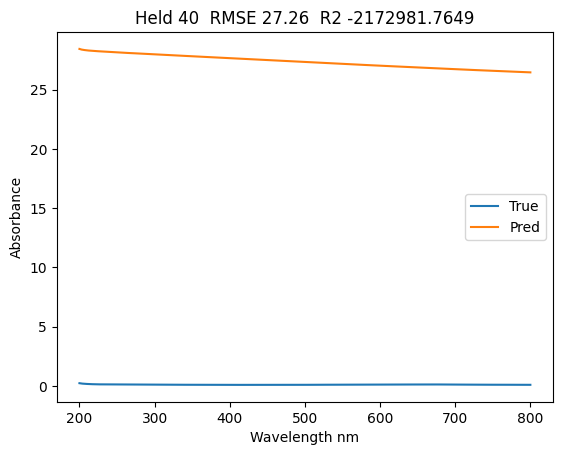

Wrote /content/A_pred_c40.csv
Compiling model...
Building feed-forward neural network...
'build' took 0.046439 s

'compile' took 0.394382 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.83e-01]    [4.43e-01]    []  
500       [1.91e-05]    [1.63e-05]    []  
1000      [4.57e-06]    [2.57e-06]    []  

Best model at step 1000:
  train loss: 4.57e-06
  test loss: 2.57e-06
  test metric: []

'train' took 5.460133 s

Compiling model...
'compile' took 0.658981 s

Training model...

Step      Train loss    Test loss     Test metric
1000      [4.57e-06]    [2.57e-06]    []  
1017      [4.57e-06]    [2.57e-06]    []  

Best model at step 1000:
  train loss: 4.57e-06
  test loss: 2.57e-06
  test metric: []

'train' took 2.850655 s

Compiling model...
Building feed-forward neural network...
'build' took 0.049233 s

'compile' took 0.433674 s

Training model...

Step      Train loss    Test loss     Test metric
0         [4.83e-01]    [4.43e-01]    []  
500    

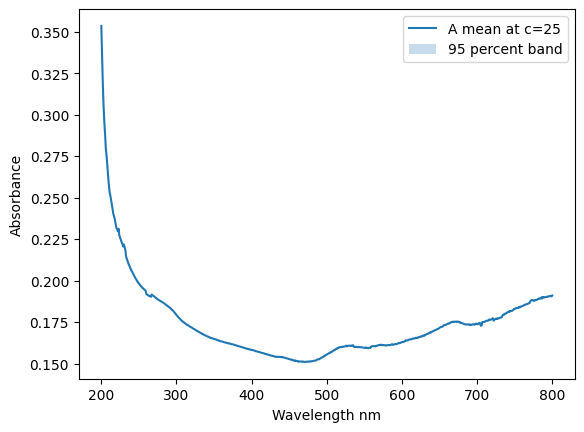

Wrote /content/A_pred_c25_ensemble.csv
{5: 3.4381353855133057, 15: 10.163474082946777, 30: 20.409822463989258, 45: 30.84921646118164, 55: 37.844276428222656}


In [36]:
# Step 5: prediction, uncertainty, plotting, CSV export (with robust restore)

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde

# 5.1 Predict absorbance for a single concentration
def predict_absorbance_for_c(model, prep, c):
    wl = prep["wl"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    A_bg = prep["A_bg"]
    c_hat = 2.0 * (float(c) - 0.0) / (60.0 - 0.0) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])
    eps = model.predict(X).reshape(-1)
    A_pred = A_bg + B_PATHLEN_CM * float(c) * eps
    return wl, A_pred

def evaluate_absorbance_metrics(A_true, A_pred):
    rmse = float(np.sqrt(np.mean((A_pred - A_true) ** 2)))
    mae  = float(np.mean(np.abs(A_pred - A_true)))
    ss_res = float(np.sum((A_true - A_pred) ** 2))
    ss_tot = float(np.sum((A_true - np.mean(A_true)) ** 2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
    return {"rmse": rmse, "mae": mae, "r2": r2}

def plot_absorbance(wl, A_true, A_pred, title="Prediction"):
    plt.figure()
    if A_true is not None:
        plt.plot(wl, A_true, label="True")
    plt.plot(wl, A_pred, label="Pred")
    plt.xlabel("Wavelength nm")
    plt.ylabel("Absorbance")
    plt.title(title)
    plt.legend()
    plt.show()

# 5.2 Train on all data and ensemble uncertainty for unseen c
def train_full_on_all(prep, seed=1337, adam_iters=1500, lr=1e-3, bfgs=True):
    set_seed(seed)
    X_tr, y_tr, X_te, y_te = build_triple_split(prep, held=None)
    data  = dde.data.Triple(X_tr, y_tr, X_te, y_te)
    net   = create_epsilon_net()
    model = dde.Model(data, net)
    model.compile("adam", lr=lr, loss="mse")
    model.train(iterations=adam_iters, display_every=500)
    if bfgs:
        model.compile("L-BFGS", loss="mse")
        model.train(display_every=100)
    return model

def ensemble_absorbance(prep, c_new, seeds=(11, 22, 33), adam_iters=1200, lr=1e-3):
    wl = prep["wl"]
    A_bg = prep["A_bg"]
    wl_hat = prep["wl_norm"].reshape(-1, 1)
    c_hat = 2.0 * (float(c_new) - 0.0) / (60.0 - 0.0) - 1.0
    X = np.hstack([wl_hat, np.full_like(wl_hat, c_hat, dtype=np.float32)])

    A_list = []
    for s in seeds:
        m = train_full_on_all(prep, seed=s, adam_iters=adam_iters, lr=lr, bfgs=True)
        eps = m.predict(X).reshape(-1)
        A = A_bg + B_PATHLEN_CM * float(c_new) * eps
        A_list.append(A)
    A_stack = np.stack(A_list, axis=0)
    A_mean = A_stack.mean(axis=0)
    A_std = A_stack.std(axis=0)
    return wl, A_mean, A_std

def plot_ensemble(wl, A_mean, A_std, label="A mean"):
    plt.figure()
    plt.plot(wl, A_mean, label=label)
    plt.fill_between(wl, A_mean - 2 * A_std, A_mean + 2 * A_std, alpha=0.25, label="95 percent band")
    plt.xlabel("Wavelength nm")
    plt.ylabel("Absorbance")
    plt.legend()
    plt.show()

# 5.3 CSV export
def export_prediction_csv(path, wl, A, A_lo=None, A_hi=None):
    df = pd.DataFrame({"wavelength_nm": wl, "A": A})
    if A_lo is not None and A_hi is not None:
        df["A_lo"] = A_lo
        df["A_hi"] = A_hi
    df.to_csv(path, index=False)
    print(f"Wrote {path}")

# 5.4 Batch predict multiple concentrations using a fitted model
def predict_grid(prep, model, c_list):
    out = {}
    for c in c_list:
        wl, A_pred = predict_absorbance_for_c(model, prep, c)
        out[c] = A_pred
    return wl, out

# 5.5 Robust restore and demo runs

# A) Restore a held fold model, with safe fallbacks if no checkpoint exists
held = 40
ckpt = cv_results[held]["ckpt"]
X_tr, y_tr, X_te, y_te = build_triple_split(prep, held=held)
data  = dde.data.Triple(X_tr, y_tr, X_te, y_te)
model = dde.Model(data, create_epsilon_net())

# must compile before restore so saver/session exist on TF v1 backend
model.compile("adam", lr=1e-3, loss="mse")

restore_ok = False
for candidate in ["best", "final"]:
    path = os.path.join(ckpt, candidate)
    try:
        model.restore(path)
        print(f"Restored from: {path}")
        restore_ok = True
        break
    except Exception as e:
        print(f"Restore failed at {path}: {e}")

# If no checkpoint, initialize weights by a tiny train to avoid uninitialized vars
if not restore_ok:
    print("No checkpoint found. Initializing weights via a tiny train step.")
    model.train(iterations=1, display_every=1)
    print("CKPT dir contents:", glob.glob(os.path.join(ckpt, "*")))

# Predict and score in absorbance space
wl, A_pred = predict_absorbance_for_c(model, prep, held)
A_true = prep["A_bg"] + prep["deltas"][held]
metrics = evaluate_absorbance_metrics(A_true, A_pred)
print("Held metrics:", metrics)
plot_absorbance(wl, A_true, A_pred, title=f"Held {held}  RMSE {metrics['rmse']:.4g}  R2 {metrics['r2']:.4f}")
export_prediction_csv("/content/A_pred_c40.csv", wl, A_pred)

# B) Ensemble for unseen concentration
wl, A_mean, A_std = ensemble_absorbance(prep, c_new=25, seeds=(101, 202, 303), adam_iters=1000, lr=1e-3)
plot_ensemble(wl, A_mean, A_std, label="A mean at c=25")
export_prediction_csv("/content/A_pred_c25_ensemble.csv", wl, A_mean, A_mean - 2*A_std, A_mean + 2*A_std)

# C) Batch predict grid for the restored (or freshly init) fold model
c_list = [5, 15, 30, 45, 55]
wl, grid_preds = predict_grid(prep, model, c_list)
print({c: float(grid_preds[c].mean()) for c in c_list})
